In [2]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torchvision.transforms import Pad, Resize
from tqdm import tqdm
import imageio
import matplotlib.pyplot as plt

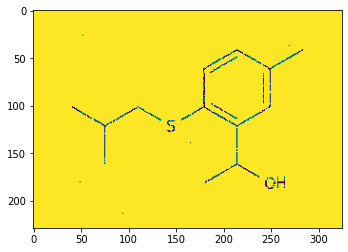

255


In [3]:
im = imageio.imread('original_data/train/0/0/0/000011a64c74.png')
plt.imshow(im)
plt.show()
print(im[2,5])

In [5]:
im = torch.Tensor(im) / 255.
im

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])

In [6]:
im.shape

torch.Size([229, 325])

In [14]:
scaler = Resize(size=(256,256))

In [15]:
im1 = scaler(im.unsqueeze(0))
print(im1.shape)

torch.Size([1, 256, 256])


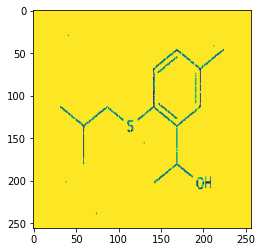

In [18]:
plt.imshow(im1[0])

In [ ]:
class FixPictureToStandardSize():
    def __init__(self, x_size, y_size):
        self.x_size  = x_size
        self.y_size  = y_size
        self.resizer = Resize(size=(256,256))
    
    def __call__(self, image):
        # x
        if image.shape[0] > self.x_size:
            rescale
        elif image.shape[0] < self.x_size:
            left = (self.x_size - image.shape[0]) // 2
            right = left + (self.x_size - image.shape[0]) % 2
            padder = Pad(left, right, 0, 0, fill=1.0)
            image = padder(image)
        # y
        if image.shape[1] > self.y_size:
            rescale
        elif image.shape[1] < self.y_size:
            down = (self.y_size - image.shape[1]) // 2
            up = down + (self.y_size - image.shape[1]) % 2
            padder = Pad(0, 0, down, up, fill=1.0)
            image = padder(image)
        return image

In [19]:
def load_pic(image_id, is_train=True):
    _ = 'train' if is_train else 'test'
    directory = 'original_data/{}/{}/{}/{}/'.format(_, image_id[0], image_id[1], image_id[2])
    return torch.Tensor(imageio.imread(directory + image_id + '.png') ) / 255.

In [20]:
class PretrainRegressionDataset(torch.utils.data.Dataset):
    def __init__(self, file='data/pretrain1/data.csv', y_file='data/pretrain1/atom_counts.npy',
                x_size=256, y_size=256):
        self.data = pd.read_csv(file)
        self.y = np.load(y_file) / 255.
        self.x_size = x_size
        self.y_size = y_size
        self.resize = Resize(size=(x_size,y_size))
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, index):
        pic = load_pic(self.data['image_id'][index]).unsqueeze(0) # C=1 channel
        pic = self.resize(pic)
        y = torch.tensor(self.y[index], dtype=torch.float32)
        return pic, y

In [21]:
dataset = PretrainRegressionDataset()

In [117]:
del dataset

In [23]:
count = 0
for elem in dataset:
    if count > 5: break
    print(elem[0].shape)
    print(elem)
    count += 1

torch.Size([1, 256, 256])
(tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]]), tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0510, 0.0000, 0.0039,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

In [53]:
class ConvBlock(nn.Module):
    def __init__(self, in1, out1, in2, out2, st1=1, st2=1, dropout=0.2):
        super().__init__()
        # nn.Conv2D(in_channels, out_channels, kernel_size=(,), stride)
        self.conv1 = nn.Conv2d(in1, out1, kernel_size=(2,2), stride=st1)
        self.conv2 = nn.Conv2d(in2, out2, kernel_size=(2,2), stride=st2)
        self.relu  = nn.ReLU()
        self.pool  = nn.MaxPool2d(kernel_size=(2,2))
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.relu(out)
        out = self.pool(out)
        # dropout
        return out

In [77]:
class CNNEncoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        n_ch = config['n_channels']
        i_ch = config['input_channels']
        f1_len = 500
        f2_len = config['output_channels'] # len(y)
        self.conv_blocks = [
            ConvBlock(in1=i_ch, out1=n_ch, in2=n_ch, out2=n_ch, st1=2).to(device),
            ConvBlock(in1=n_ch, out1=n_ch, in2=n_ch, out2=n_ch).to(device)
        ]
        self.fc1 = nn.Linear(n_ch * 30 * 30, f1_len) # FIXME dimensions
        self.fc2 = nn.Linear(f1_len, f2_len)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        for conv_block in self.conv_blocks:
            x = conv_block(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        return x

In [78]:
def train_epoch(data_loader, cnn, optimizer, criterion):
    for x_batch, y_batch in tqdm(data_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        predictions = cnn(x_batch)
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()

In [79]:
def train_model(dataset, cnn, n_epochs, batch_size):
    data_loader = torch.utils.data.DataLoader(dataset, batch_size)
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(cnn.parameters(), lr=0.01)
    for i in range(n_epochs):
        print('Starting epoch {}'.format(i))
        train_epoch(data_loader, cnn, optimizer, criterion)

In [80]:
cfg = dict()
cfg['n_channels'] = 50
cfg['input_channels'] = 1
cfg['output_channels'] = 100

In [81]:
cnn = CNNEncoder(cfg)

In [85]:
%%time
train_model(dataset, cnn, 1, 50)

  0%|          | 0/200 [00:00<?, ?it/s]

Starting epoch 0


100%|██████████| 200/200 [00:33<00:00,  5.89it/s]

CPU times: user 2min 3s, sys: 4.42 s, total: 2min 7s
Wall time: 34 s


In [64]:
data_loader = torch.utils.data.DataLoader(dataset, 1)
for x, y in data_loader:
    cnn.eval()
    pred = cnn.forward(x)
    true = y
    break

In [71]:
pred > 0.01

tensor([[ True, False,  True,  True, False, False,  True, False,  True, False,
         False, False, False,  True,  True, False, False, False, False, False,
         False, False, False,  True, False,  True, False,  True, False,  True,
         False, False, False, False,  True,  True,  True, False, False, False,
         False,  True,  True,  True, False, False, False,  True, False, False,
         False, False, False, False, False, False,  True, False,  True, False,
          True, False, False, False, False, False, False,  True, False, False,
          True,  True, False, False, False, False, False,  True, False,  True,
         False, False, False, False,  True,  True, False, False, False, False,
         False,  True, False,  True, False, False, False,  True, False, False]])

In [75]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [82]:
cnn.to(device)

CNNEncoder(
  (fc1): Linear(in_features=45000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (relu): ReLU()
)